***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying bottom-up approach. (Fine-to-Coarse)
- Changing the Secondary Capsule Dimension:
    - 16D>12D>8D (Fine>Medium>Coarse)
    - Use Hinge Loss (MarginLoss) for each level + Consistency Loss.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "5" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  5
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_1_1')

FOLDER CREATED =  ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_W_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5109 - prediction_coarse_accuracy: 0.3637 - prediction_medium_accuracy: 0.1933 - prediction_fine_accuracy: 0.0902
  • Coarse Accuracy = 36.37% | Val_Accuracy = 50.41% | LossWeight = 0.40 
  • Medium Accuracy = 19.33% | Val_Accuracy = 28.31% | LossWeight = 0.46 
  • Fine   Accuracy = 9.02% | Val_Accuracy = 11.62% | LossWeight = 0.13 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.11620, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 152s 183ms/step - loss: 0.5109 - prediction_coarse_accuracy: 0.3637 - prediction_medium_accuracy: 0.1933 - prediction_fine_accuracy: 0.0902 - val_loss: 0.3980 - val_prediction_coarse_accuracy: 0.5041 - val_prediction_medium_accuracy: 0.2831 - val_prediction_fine_accuracy: 0.1162 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3473 - prediction_coarse_accura

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1189 - prediction_coarse_accuracy: 0.9174 - prediction_medium_accuracy: 0.8672 - prediction_fine_accuracy: 0.6567
  • Coarse Accuracy = 91.74% | Val_Accuracy = 83.23% | LossWeight = 0.29 
  • Medium Accuracy = 86.72% | Val_Accuracy = 73.76% | LossWeight = 0.42 
  • Fine   Accuracy = 65.67% | Val_Accuracy = 57.29% | LossWeight = 0.28 

Epoch 18: val_prediction_fine_accuracy improved from 0.56350 to 0.57290, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_W_C_loss\epoch-best.h5
781/781 [==============================] - 143s 183ms/step - loss: 0.1189 - prediction_coarse_accuracy: 0.9174 - prediction_medium_accuracy: 0.8672 - prediction_fine_accuracy: 0.6567 - val_loss: 0.1396 - val_prediction_coarse_accuracy: 0.8323 - val_prediction_medium_accuracy: 0.7376 - val_prediction_fine_accuracy: 0.5729 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1163 - prediction_co

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1003 - prediction_coarse_accuracy: 0.9411 - prediction_medium_accuracy: 0.9135 - prediction_fine_accuracy: 0.7207
  • Coarse Accuracy = 94.11% | Val_Accuracy = 83.69% | LossWeight = 0.29 
  • Medium Accuracy = 91.35% | Val_Accuracy = 74.66% | LossWeight = 0.39 
  • Fine   Accuracy = 72.07% | Val_Accuracy = 59.44% | LossWeight = 0.32 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.59980
781/781 [==============================] - 143s 183ms/step - loss: 0.1003 - prediction_coarse_accuracy: 0.9411 - prediction_medium_accuracy: 0.9135 - prediction_fine_accuracy: 0.7207 - val_loss: 0.1361 - val_prediction_coarse_accuracy: 0.8369 - val_prediction_medium_accuracy: 0.7466 - val_prediction_fine_accuracy: 0.5944 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0983 - prediction_coarse_accuracy: 0.9428 - prediction_medium_accuracy: 0.9172 - prediction_fine_accuracy: 

781/781 [==============================] - ETA: 0s - loss: 0.0873 - prediction_coarse_accuracy: 0.9557 - prediction_medium_accuracy: 0.9399 - prediction_fine_accuracy: 0.7794
  • Coarse Accuracy = 95.57% | Val_Accuracy = 85.11% | LossWeight = 0.30 
  • Medium Accuracy = 93.99% | Val_Accuracy = 76.69% | LossWeight = 0.36 
  • Fine   Accuracy = 77.94% | Val_Accuracy = 62.72% | LossWeight = 0.34 

Epoch 45: val_prediction_fine_accuracy did not improve from 0.62930
781/781 [==============================] - 143s 183ms/step - loss: 0.0873 - prediction_coarse_accuracy: 0.9557 - prediction_medium_accuracy: 0.9399 - prediction_fine_accuracy: 0.7794 - val_loss: 0.1284 - val_prediction_coarse_accuracy: 0.8511 - val_prediction_medium_accuracy: 0.7669 - val_prediction_fine_accuracy: 0.6272 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0866 - prediction_coarse_accuracy: 0.9544 - prediction_medium_accuracy: 0.9405 - prediction_fine_accuracy: 0.7857
  • Co

781/781 [==============================] - 143s 183ms/step - loss: 0.0857 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9438 - prediction_fine_accuracy: 0.7979 - val_loss: 0.1301 - val_prediction_coarse_accuracy: 0.8531 - val_prediction_medium_accuracy: 0.7682 - val_prediction_fine_accuracy: 0.6330 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0856 - prediction_coarse_accuracy: 0.9564 - prediction_medium_accuracy: 0.9424 - prediction_fine_accuracy: 0.7967
  • Coarse Accuracy = 95.64% | Val_Accuracy = 85.62% | LossWeight = 0.31 
  • Medium Accuracy = 94.24% | Val_Accuracy = 77.12% | LossWeight = 0.36 
  • Fine   Accuracy = 79.67% | Val_Accuracy = 63.23% | LossWeight = 0.33 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.63360
781/781 [==============================] - 142s 182ms/step - loss: 0.0856 - prediction_coarse_accuracy: 0.9564 - prediction_medium_accuracy: 0.9424 - prediction_fine_accuracy: 0.796

781/781 [==============================] - 143s 183ms/step - loss: 0.0848 - prediction_coarse_accuracy: 0.9565 - prediction_medium_accuracy: 0.9442 - prediction_fine_accuracy: 0.8095 - val_loss: 0.1286 - val_prediction_coarse_accuracy: 0.8574 - val_prediction_medium_accuracy: 0.7759 - val_prediction_fine_accuracy: 0.6377 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0845 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.8070
  • Coarse Accuracy = 95.76% | Val_Accuracy = 85.97% | LossWeight = 0.31 
  • Medium Accuracy = 94.58% | Val_Accuracy = 77.43% | LossWeight = 0.36 
  • Fine   Accuracy = 80.70% | Val_Accuracy = 63.77% | LossWeight = 0.33 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.63770
781/781 [==============================] - 143s 183ms/step - loss: 0.0845 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9458 - prediction_fine_accuracy: 0.807

Epoch 73/100
781/781 [==============================] - ETA: 0s - loss: 0.0836 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 0.8145
  • Coarse Accuracy = 95.81% | Val_Accuracy = 85.89% | LossWeight = 0.31 
  • Medium Accuracy = 94.52% | Val_Accuracy = 77.54% | LossWeight = 0.37 
  • Fine   Accuracy = 81.45% | Val_Accuracy = 63.89% | LossWeight = 0.32 

Epoch 73: val_prediction_fine_accuracy did not improve from 0.64190
781/781 [==============================] - 143s 183ms/step - loss: 0.0836 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 0.8145 - val_loss: 0.1280 - val_prediction_coarse_accuracy: 0.8589 - val_prediction_medium_accuracy: 0.7754 - val_prediction_fine_accuracy: 0.6389 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0835 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9455 - prediction_fine_accuracy: 

781/781 [==============================] - 143s 184ms/step - loss: 0.0838 - prediction_coarse_accuracy: 0.9565 - prediction_medium_accuracy: 0.9444 - prediction_fine_accuracy: 0.8156 - val_loss: 0.1276 - val_prediction_coarse_accuracy: 0.8589 - val_prediction_medium_accuracy: 0.7762 - val_prediction_fine_accuracy: 0.6410 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0835 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.8173
  • Coarse Accuracy = 95.79% | Val_Accuracy = 85.92% | LossWeight = 0.32 
  • Medium Accuracy = 94.60% | Val_Accuracy = 77.60% | LossWeight = 0.36 
  • Fine   Accuracy = 81.73% | Val_Accuracy = 64.04% | LossWeight = 0.32 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.64190
781/781 [==============================] - 143s 184ms/step - loss: 0.0835 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.817

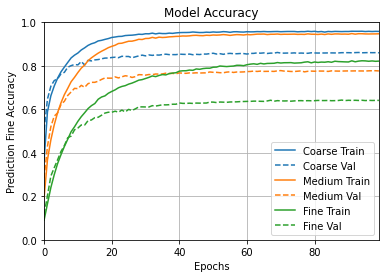

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

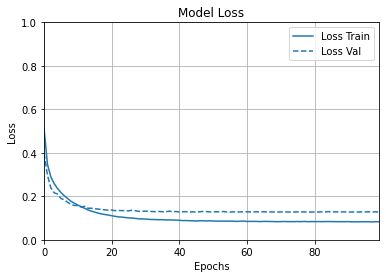

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 37ms/step - loss: 0.1933 - prediction_coarse_loss: 0.1248 - prediction_medium_loss: 0.1787 - prediction_fine_loss: 0.2786 - prediction_coarse_accuracy: 0.8602 - prediction_medium_accuracy: 0.7766 - prediction_fine_accuracy: 0.6412
1. loss ==> 0.19334615767002106
2. prediction_coarse_loss ==> 0.12481041252613068
3. prediction_medium_loss ==> 0.17870646715164185
4. prediction_fine_loss ==> 0.27858904004096985
5. prediction_coarse_accuracy ==> 0.8601999878883362
6. prediction_medium_accuracy ==> 0.7766000032424927
7. prediction_fine_accuracy ==> 0.6412000060081482
313/313 [==============================] - 10s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

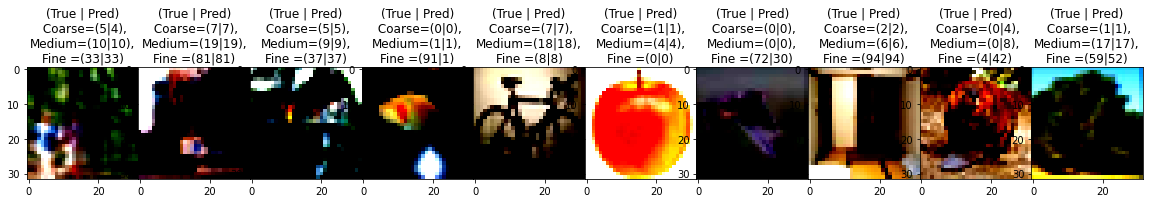

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 715   16   25   21  191    9   11   12]
 [   7 1371   27   28   38   22    2    5]
 [   5   32 1365   21   27   13   12   25]
 [  22   42   28  794  104    1    3    6]
 [ 105   32   56   85 2174   12   15   21]
 [  10   28   30    5   38  859    0   30]
 [   5    8   17   13   40    0  408    9]
 [   7    3   20    5   29   20    0  916]]

  • MEDIUM LEVEL 
[[311  32   0   1   0   8   3   3  15   2   4  14  19  11   7  36  28   0
    4   2]
 [ 22 368   6   5   9   6   3   7   1   0   5   2   6  10   7  23  10   0
    3   7]
 [  0   3 448   5  14   3   1  11   1   1   2   0   1   4   3   2   0   0
    0   1]
 [  0   3   7 405  12  31  11   1   2   2   0   2   2   5   4   4   1   0
    2   6]
 [  1   3  22   7 423   7   2   9   6   1   1   1   4   5   1   3   1   1
    2   0]
 [  2   3   3  28   3 391  19   3   3   3   2   2   1   8   7   8   2   2
    2   8]
 [  0   1   1  11   1  25 430   4   2   4   2   0   1   1   5   1   1   1
    6   3]


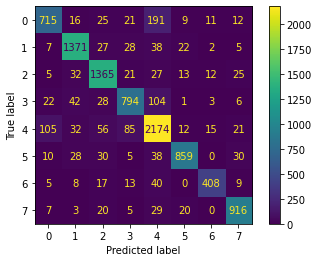

              precision    recall  f1-score   support

           0    0.81621   0.71500   0.76226      1000
           1    0.89491   0.91400   0.90435      1500
           2    0.87054   0.91000   0.88983      1500
           3    0.81687   0.79400   0.80527      1000
           4    0.82317   0.86960   0.84575      2500
           5    0.91774   0.85900   0.88740      1000
           6    0.90466   0.81600   0.85804       500
           7    0.89453   0.91600   0.90514      1000

    accuracy                        0.86020     10000
   macro avg    0.86733   0.84920   0.85726     10000
weighted avg    0.86038   0.86020   0.85947     10000


  • MEDIUM LEVEL 


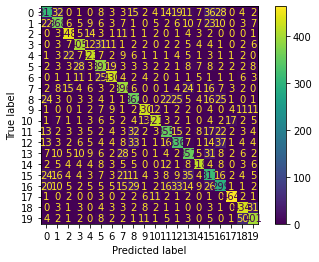

              precision    recall  f1-score   support

           0    0.69420   0.62200   0.65612       500
           1    0.76349   0.73600   0.74949       500
           2    0.84528   0.89600   0.86990       500
           3    0.80198   0.81000   0.80597       500
           4    0.83432   0.84600   0.84012       500
           5    0.72677   0.78200   0.75337       500
           6    0.83984   0.86000   0.84980       500
           7    0.75429   0.79200   0.77268       500
           8    0.69084   0.72400   0.70703       500
           9    0.87935   0.86000   0.86957       500
          10    0.89006   0.84200   0.86536       500
          11    0.76017   0.71000   0.73423       500
          12    0.72103   0.67200   0.69565       500
          13    0.70833   0.71400   0.71116       500
          14    0.86364   0.83600   0.84959       500
          15    0.59252   0.63400   0.61256       500
          16    0.63889   0.59800   0.61777       500
          17    0.92430   0

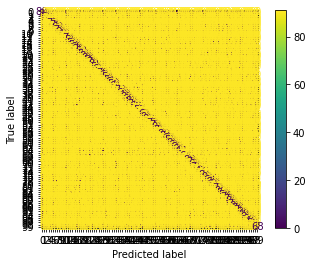

              precision    recall  f1-score   support

           0    0.81633   0.80000   0.80808       100
           1    0.72807   0.83000   0.77570       100
           2    0.51546   0.50000   0.50761       100
           3    0.48276   0.42000   0.44920       100
           4    0.46237   0.43000   0.44560       100
           5    0.66364   0.73000   0.69524       100
           6    0.66964   0.75000   0.70755       100
           7    0.67391   0.62000   0.64583       100
           8    0.81443   0.79000   0.80203       100
           9    0.77143   0.81000   0.79024       100
          10    0.58333   0.49000   0.53261       100
          11    0.44330   0.43000   0.43655       100
          12    0.69811   0.74000   0.71845       100
          13    0.58511   0.55000   0.56701       100
          14    0.47581   0.59000   0.52679       100
          15    0.54369   0.56000   0.55172       100
          16    0.67647   0.69000   0.68317       100
          17    0.84946   0

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7567733333333334 
Hierarchical Recall = 0.7758333333333334 
Hierarchical F1-Score = 0.7642412698412699 
Consistency =  0.8929 
Exact Match =  0.6164


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1089 - prediction_coarse_accuracy: 0.9293 - prediction_medium_accuracy: 0.8989 - prediction_fine_accuracy: 0.7478
  • Coarse Accuracy = 92.93% | Val_Accuracy = 82.54% | LossWeight = 0.32 
  • Medium Accuracy = 89.89% | Val_Accuracy = 72.50% | LossWeight = 0.41 
  • Fine   Accuracy = 74.78% | Val_Accuracy = 59.13% | LossWeight = 0.27 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.64260
781/781 [==============================] - 143s 183ms/step - loss: 0.1089 - prediction_coarse_accuracy: 0.9293 - prediction_medium_accuracy: 0.8989 - prediction_fine_accuracy: 0.7478 - val_loss: 0.1513 - val_prediction_coarse_accuracy: 0.8254 - val_prediction_medium_accuracy: 0.7250 - val_prediction_fine_accuracy: 0.5913 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1078 - prediction_coarse_accuracy: 0.9321 - prediction_medium_accuracy: 0.9021 - prediction_fine_accuracy: 0.7478


781/781 [==============================] - 143s 183ms/step - loss: 0.0995 - prediction_coarse_accuracy: 0.9402 - prediction_medium_accuracy: 0.9182 - prediction_fine_accuracy: 0.7719 - val_loss: 0.1382 - val_prediction_coarse_accuracy: 0.8380 - val_prediction_medium_accuracy: 0.7508 - val_prediction_fine_accuracy: 0.6120 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0974 - prediction_coarse_accuracy: 0.9438 - prediction_medium_accuracy: 0.9213 - prediction_fine_accuracy: 0.7777
  • Coarse Accuracy = 94.38% | Val_Accuracy = 83.52% | LossWeight = 0.31 
  • Medium Accuracy = 92.13% | Val_Accuracy = 74.55% | LossWeight = 0.40 
  • Fine   Accuracy = 77.77% | Val_Accuracy = 61.13% | LossWeight = 0.29 

Epoch 11: val_prediction_fine_accuracy did not improve from 0.64260
781/781 [==============================] - 143s 182ms/step - loss: 0.0974 - prediction_coarse_accuracy: 0.9438 - prediction_medium_accuracy: 0.9213 - prediction_fine_accuracy: 0.7777 - 

781/781 [==============================] - 143s 183ms/step - loss: 0.0847 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9445 - prediction_fine_accuracy: 0.8488 - val_loss: 0.1291 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7767 - val_prediction_fine_accuracy: 0.6452 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: 0.0844 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.9445 - prediction_fine_accuracy: 0.8511
  • Coarse Accuracy = 95.62% | Val_Accuracy = 85.86% | LossWeight = 0.34 
  • Medium Accuracy = 94.45% | Val_Accuracy = 77.46% | LossWeight = 0.39 
  • Fine   Accuracy = 85.11% | Val_Accuracy = 64.35% | LossWeight = 0.27 

Epoch 30: val_prediction_fine_accuracy did not improve from 0.64520
781/781 [==============================] - 143s 183ms/step - loss: 0.0844 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.9445 - prediction_fine_accuracy: 0.851

Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0824 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.8700
  • Coarse Accuracy = 95.84% | Val_Accuracy = 86.13% | LossWeight = 0.35 
  • Medium Accuracy = 94.76% | Val_Accuracy = 78.12% | LossWeight = 0.40 
  • Fine   Accuracy = 87.00% | Val_Accuracy = 64.97% | LossWeight = 0.25 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.65300
781/781 [==============================] - 143s 183ms/step - loss: 0.0824 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.8700 - val_loss: 0.1298 - val_prediction_coarse_accuracy: 0.8613 - val_prediction_medium_accuracy: 0.7812 - val_prediction_fine_accuracy: 0.6497 - lr: 2.2594e-04
Epoch 40/100
781/781 [==============================] - ETA: 0s - loss: 0.0819 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9485 - prediction_fine_accuracy: 

781/781 [==============================] - ETA: 0s - loss: 0.0802 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.8912
  • Coarse Accuracy = 96.27% | Val_Accuracy = 86.77% | LossWeight = 0.36 
  • Medium Accuracy = 95.29% | Val_Accuracy = 78.64% | LossWeight = 0.40 
  • Fine   Accuracy = 89.12% | Val_Accuracy = 65.86% | LossWeight = 0.24 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.65890
781/781 [==============================] - 143s 183ms/step - loss: 0.0802 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.8912 - val_loss: 0.1288 - val_prediction_coarse_accuracy: 0.8677 - val_prediction_medium_accuracy: 0.7864 - val_prediction_fine_accuracy: 0.6586 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0802 - prediction_coarse_accuracy: 0.9622 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.8912
  • Co

781/781 [==============================] - 143s 183ms/step - loss: 0.0795 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9524 - prediction_fine_accuracy: 0.8948 - val_loss: 0.1294 - val_prediction_coarse_accuracy: 0.8684 - val_prediction_medium_accuracy: 0.7864 - val_prediction_fine_accuracy: 0.6597 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0802 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.8966
  • Coarse Accuracy = 96.24% | Val_Accuracy = 86.82% | LossWeight = 0.36 
  • Medium Accuracy = 95.21% | Val_Accuracy = 78.50% | LossWeight = 0.41 
  • Fine   Accuracy = 89.66% | Val_Accuracy = 65.89% | LossWeight = 0.23 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.66050
781/781 [==============================] - 143s 183ms/step - loss: 0.0802 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.896

Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0790 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9543 - prediction_fine_accuracy: 0.9010
  • Coarse Accuracy = 96.30% | Val_Accuracy = 86.70% | LossWeight = 0.37 
  • Medium Accuracy = 95.43% | Val_Accuracy = 78.84% | LossWeight = 0.41 
  • Fine   Accuracy = 90.10% | Val_Accuracy = 65.97% | LossWeight = 0.23 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.66150
781/781 [==============================] - 143s 183ms/step - loss: 0.0790 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9543 - prediction_fine_accuracy: 0.9010 - val_loss: 0.1308 - val_prediction_coarse_accuracy: 0.8670 - val_prediction_medium_accuracy: 0.7884 - val_prediction_fine_accuracy: 0.6597 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0804 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 

781/781 [==============================] - 142s 182ms/step - loss: 0.0799 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9516 - prediction_fine_accuracy: 0.9007 - val_loss: 0.1311 - val_prediction_coarse_accuracy: 0.8677 - val_prediction_medium_accuracy: 0.7895 - val_prediction_fine_accuracy: 0.6616 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0794 - prediction_coarse_accuracy: 0.9632 - prediction_medium_accuracy: 0.9536 - prediction_fine_accuracy: 0.9015
  • Coarse Accuracy = 96.32% | Val_Accuracy = 86.86% | LossWeight = 0.36 
  • Medium Accuracy = 95.36% | Val_Accuracy = 78.80% | LossWeight = 0.41 
  • Fine   Accuracy = 90.15% | Val_Accuracy = 66.21% | LossWeight = 0.23 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.66270
781/781 [==============================] - 143s 183ms/step - loss: 0.0794 - prediction_coarse_accuracy: 0.9632 - prediction_medium_accuracy: 0.9536 - prediction_fine_accuracy: 0.901

In [24]:
history_dict = history.history

(0.0, 1.0)

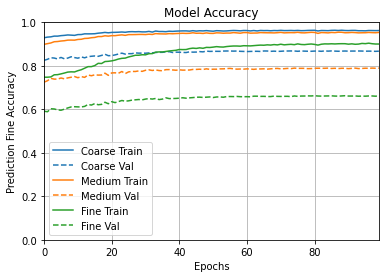

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

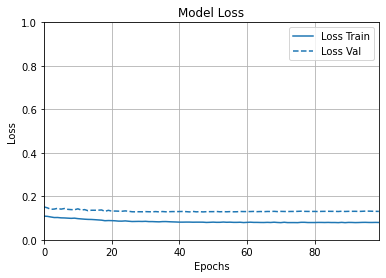

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 36ms/step - loss: 0.1767 - prediction_coarse_loss: 0.1143 - prediction_medium_loss: 0.1821 - prediction_fine_loss: 0.2683 - prediction_coarse_accuracy: 0.8675 - prediction_medium_accuracy: 0.7895 - prediction_fine_accuracy: 0.6617
1. loss ==> 0.17674508690834045
2. prediction_coarse_loss ==> 0.11428699642419815
3. prediction_medium_loss ==> 0.18205270171165466
4. prediction_fine_loss ==> 0.26833727955818176
5. prediction_coarse_accuracy ==> 0.8675000071525574
6. prediction_medium_accuracy ==> 0.7894999980926514
7. prediction_fine_accuracy ==> 0.6617000102996826
313/313 [==============================] - 10s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

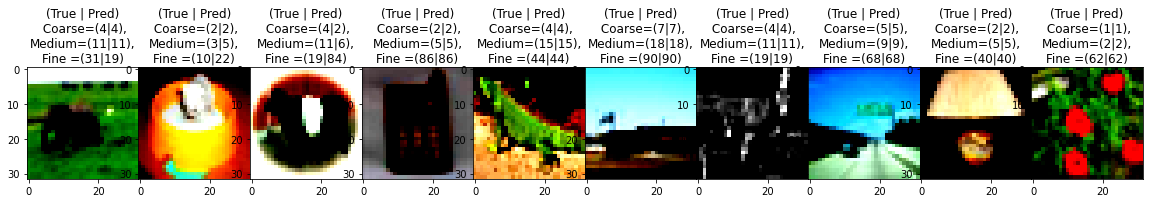

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 726    9   20   23  189   11    8   14]
 [   4 1377   30   24   38   21    1    5]
 [   6   26 1383   13   30    9    9   24]
 [  20   38   35  779  118    1    2    7]
 [  84   26   47   86 2210   11   11   25]
 [   6   20   25   10   28  877    1   33]
 [   3   10   11   10   45    2  415    4]
 [   6    1   25    5   30   25    0  908]]

  • MEDIUM LEVEL 
[[331  26   1   0   1   5   1   3  17   3   3  12  22  12   4  32  20   1
    4   2]
 [ 32 366   2   4   5   3   2   7   3   3   6   3   9   9   7  16  12   0
    4   7]
 [  1   2 452   5  10   4   2  10   0   2   2   0   0   4   0   4   0   0
    0   2]
 [  2   3   6 407  14  28   9   2   2   4   0   2   1   4   4   3   2   0
    3   4]
 [  0   1  20   6 428   8   1   5   5   1   2   2   4   6   0   1   4   4
    2   0]
 [  3   3   0  25   4 392  24   3   2   7   3   2   1   8   6   3   2   3
    2   7]
 [  0   2   1   9   1  22 438   3   3   3   2   0   1   1   3   2   0   1
    2   6]


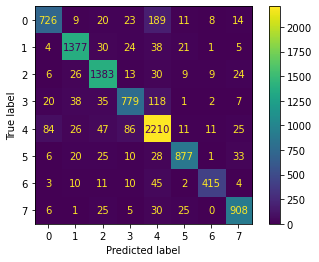

              precision    recall  f1-score   support

           0    0.84912   0.72600   0.78275      1000
           1    0.91374   0.91800   0.91586      1500
           2    0.87754   0.92200   0.89922      1500
           3    0.82000   0.77900   0.79897      1000
           4    0.82217   0.88400   0.85197      2500
           5    0.91641   0.87700   0.89627      1000
           6    0.92841   0.83000   0.87645       500
           7    0.89020   0.90800   0.89901      1000

    accuracy                        0.86750     10000
   macro avg    0.87720   0.85550   0.86506     10000
weighted avg    0.86823   0.86750   0.86678     10000


  • MEDIUM LEVEL 


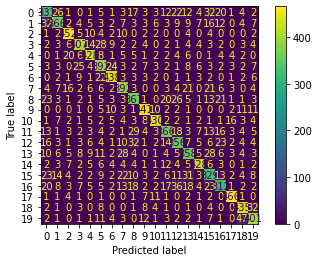

              precision    recall  f1-score   support

           0    0.68107   0.66200   0.67140       500
           1    0.79913   0.73200   0.76409       500
           2    0.85606   0.90400   0.87938       500
           3    0.82892   0.81400   0.82139       500
           4    0.84585   0.85600   0.85089       500
           5    0.72727   0.78400   0.75457       500
           6    0.85214   0.87600   0.86391       500
           7    0.75969   0.78400   0.77165       500
           8    0.72673   0.73400   0.73035       500
           9    0.86301   0.88200   0.87240       500
          10    0.88660   0.86000   0.87310       500
          11    0.77542   0.73200   0.75309       500
          12    0.70635   0.71200   0.70916       500
          13    0.71743   0.71600   0.71672       500
          14    0.88981   0.85600   0.87258       500
          15    0.64008   0.65800   0.64892       500
          16    0.70588   0.62400   0.66242       500
          17    0.91732   0

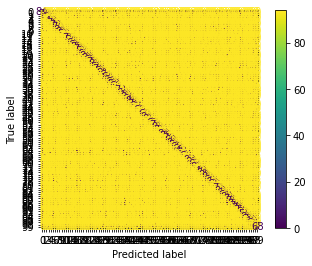

              precision    recall  f1-score   support

           0    0.83168   0.84000   0.83582       100
           1    0.70909   0.78000   0.74286       100
           2    0.48454   0.47000   0.47716       100
           3    0.52632   0.40000   0.45455       100
           4    0.53333   0.48000   0.50526       100
           5    0.67857   0.76000   0.71698       100
           6    0.68750   0.77000   0.72642       100
           7    0.72917   0.70000   0.71429       100
           8    0.83168   0.84000   0.83582       100
           9    0.77143   0.81000   0.79024       100
          10    0.59551   0.53000   0.56085       100
          11    0.43689   0.45000   0.44335       100
          12    0.76531   0.75000   0.75758       100
          13    0.62791   0.54000   0.58065       100
          14    0.57658   0.64000   0.60664       100
          15    0.60784   0.62000   0.61386       100
          16    0.81818   0.72000   0.76596       100
          17    0.83871   0

In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7700116666666665 
Hierarchical Recall = 0.7873333333333332 
Hierarchical F1-Score = 0.7767793650793651 
Consistency =  0.9 
Exact Match =  0.6404
